In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)
- Löwdin orthonormalization

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

In [2]:
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-Hartree/scf.csv", index_col=[0,1,2])
hybrid_frame.loc[mol,:,:]

Localize  SCF energy  Helmholtz   Lowdin       KAIN  Fock operator  Fock matrix  Total SCF
MPI OMP                                                                                            
1   1    474.6710   289.51500  6163.6900  56.7616  50.342800      218.40300     399.4830   7707.260
    2    292.3120   152.27900  3061.2300  38.7188  29.766600      108.68600     249.2180   3973.910
    4    200.3350    84.37710  1586.4300  29.4473  18.755000       55.04890     156.0790   2161.330
    8    152.7850    51.51480   872.0010  25.9097  14.155100       29.92860     116.5280   1291.080
    16   134.9690    36.49630   538.4050  23.6030  12.516200       18.03680     117.7490    908.099
2   1    265.0520   148.82200  3131.1900  43.4031  25.829000      153.97300     210.1820   4017.000
    16    88.4447    18.05430   275.4540  18.8204   6.840280       14.76870      67.7912    512.812
4   1    164.5300    82.19800  1579.2500  60.2692  15.345800      120.59800     113.1850   2234.750
    16    58.2876     8.58628   129.9950  17.7702   3.244200        9.34572      39.9074    283.368
8   1    101.4890    40.84840   823.2730  70.8752   8.114030      100.38700      73.0342   1247.720
    16    38.6986     5.03847    74.2359  15.4876   1.842590        8.35030      28.7904    187.972
16  1     68.8092    17.41200   323.0080  68.4573   4.255720       59.50520      37.6199    599.557
    16    25.0524     2.32068    34.0694  14.6825   0.900428        5.32517      14.8100    106.637

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

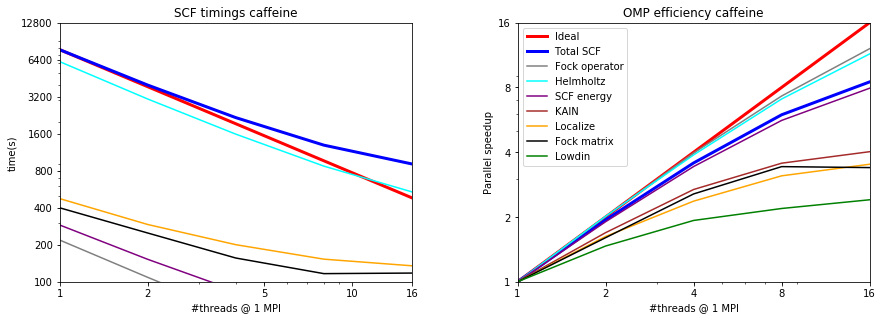

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,,
1,474.671,289.5150,6163.690,56.7616,50.3428,218.4030,399.483,7707.260
2,292.312,152.2790,3061.230,38.7188,29.7666,108.6860,249.218,3973.910
4,200.335,84.3771,1586.430,29.4473,18.7550,55.0489,156.079,2161.330
8,152.785,51.5148,872.001,25.9097,14.1551,29.9286,116.528,1291.080
16,134.969,36.4963,538.405,23.6030,12.5162,18.0368,117.749,908.099


In [6]:
mpi=1
mol='caffeine'
omp_frame = pd.read_csv("caffeine-Hartree/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[mol,mpi]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], lw=3, c='blue')
plt.plot(omp_series['Fock operator'], c='gray')
plt.plot(omp_series['Helmholtz'], c='cyan')
plt.plot(omp_series['SCF energy'], c='purple')
plt.plot(omp_series['KAIN'], c='brown')
plt.plot(omp_series['Localize'], c='orange')
plt.plot(omp_series['Fock matrix'], c='black')
plt.plot(omp_series['Lowdin'], c='green')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 100, 12800])
plt.yticks([100, 200, 400, 800, 1600, 3200, 6400, 12800], [100, 200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 5, 10, 16], [1, 2, 5, 10, 16])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + mol)
plt.plot(omp_series.index, omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], c='blue', lw=3)
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black')
plt.plot(mpi*omp_series['Lowdin'][mpi]/omp_series['Lowdin'], c='green')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[mol,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

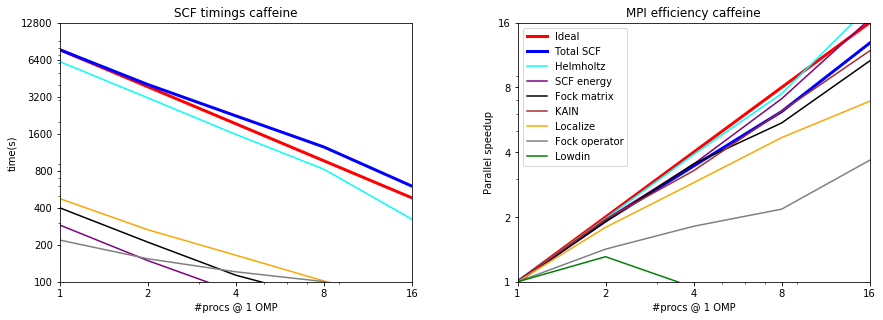

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,474.6710,289.5150,6163.690,56.7616,50.34280,218.4030,399.4830,7707.260
2,265.0520,148.8220,3131.190,43.4031,25.82900,153.9730,210.1820,4017.000
4,164.5300,82.1980,1579.250,60.2692,15.34580,120.5980,113.1850,2234.750
8,101.4890,40.8484,823.273,70.8752,8.11403,100.3870,73.0342,1247.720
16,68.8092,17.4120,323.008,68.4573,4.25572,59.5052,37.6199,599.557


In [8]:
omp=1
ref=1
mol='caffeine'
mpi_frame = pd.read_csv("caffeine-Hartree/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], c='blue', lw=3)
plt.plot(mpi_series['Helmholtz'], c='cyan')
plt.plot(mpi_series['SCF energy'], c='purple')
plt.plot(mpi_series['Fock matrix'], c='black')
plt.plot(mpi_series['KAIN'], c='brown')
plt.plot(mpi_series['Localize'], c='orange')
plt.plot(mpi_series['Fock operator'], c='gray')
plt.plot(mpi_series['Lowdin'], c='green')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 100, 12800])
plt.yticks([100, 200, 400, 800, 1600, 3200, 6400, 12800], [100, 200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + mol)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray')
plt.plot(ref*mpi_series['Lowdin'][ref]/mpi_series['Lowdin'], c='green')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed 10 OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

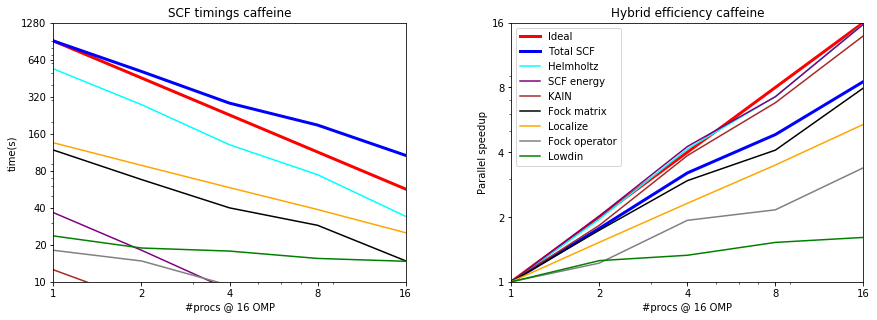

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,134.9690,36.49630,538.4050,23.6030,12.516200,18.03680,117.7490,908.099
2,88.4447,18.05430,275.4540,18.8204,6.840280,14.76870,67.7912,512.812
4,58.2876,8.58628,129.9950,17.7702,3.244200,9.34572,39.9074,283.368
8,38.6986,5.03847,74.2359,15.4876,1.842590,8.35030,28.7904,187.972
16,25.0524,2.32068,34.0694,14.6825,0.900428,5.32517,14.8100,106.637


In [11]:
omp=16
ref=1
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-Hartree/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], c='blue', lw=3)
plt.plot(hybrid_series['Helmholtz'], c='cyan')
plt.plot(hybrid_series['SCF energy'], c='purple')
plt.plot(hybrid_series['KAIN'], c='brown')
plt.plot(hybrid_series['Fock matrix'], c='black')
plt.plot(hybrid_series['Localize'], c='orange')
plt.plot(hybrid_series['Fock operator'], c='gray')
plt.plot(hybrid_series['Lowdin'], c='green')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 10, 1280])
plt.yticks([10, 20, 40, 80, 160, 320, 640, 1280], [10, 20, 40, 80, 160, 320, 640, 1280])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + mol)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray')
plt.plot(ref*hybrid_series['Lowdin'][ref]/hybrid_series['Lowdin'], c='green')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1, 16, 1, 16])
plt.yticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp,:]